<a href="https://colab.research.google.com/github/Smooj/Data-Science/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction: Bangaluru Housing Data

---


The objective of this project is to build a model that will predict housing prices base on certain criteria such as the number of bedrooms, bathrooms, size of the place, and location. The dataset I will be using is the Bangaluru, India housing data.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


I will builda regression model that will predict price. In this dataset the price is in Indian Rupees

In [ ]:
df.shape

(13320, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


There are missing values in certain columns that I will either impute or drop. Columns within this dataset that I need to explore are area type and society as I am not sure what they repersent.

In [ ]:
df.groupby('area_type')['area_type'].agg('count')

,area_type
area_type,
Built-up Area,2418
Carpet Area,87
Plot Area,2025
Super built-up Area,8790


Area type is the type/amount of space avaliable. A Built-up area is the total amount of avaliable space within the property. A Carpet area is the total usuable space. Plot area is the total area enclosed by a fence. Super built-up area is a built-up area but also includes elevators, lobbies. This sounds more like a condo and the buyer/renter will be required to pay in maintence fees. This feature isn't important for this model since we have the size and total square feet columns which should reflect the same information for our model.

In [ ]:
df.groupby('society')['society'].agg('count')

,society
society,
3Codeli,2
7 ise P,1
A idse,2
A rtsai,1
ACersd,1
...,...
Zonce E,2
Zostaa,3
i1ncyRe,1


Not sure what society represents. It could represent the "class" of the area. It is also not relevant for our model and will be dropped.

In [ ]:
df.corr(numeric_only=True).style.background_gradient(cmap ='coolwarm')

,bath,balcony,price
bath,1.000000,0.204201,0.456345
balcony,0.204201,1.000000,0.120355
price,0.456345,0.120355,1.000000


In [ ]:
#Drop columns that are not needed
df.drop(['area_type', 'availability', 'society', 'balcony'], inplace=True, axis=1)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


Though avaliablity holds some value in the housing prices. I don't think it holds a siginificant value and will drop it. The heatmap indicated that balacony is not an important feature so I will drop that as well

In [ ]:
len(df)

13320

Let's see how many null values there are

In [ ]:
(df.isnull().sum()/len(df))*100

,0
location,0.007508
size,0.120120
total_sqft,0.000000
bath,0.548048
price,0.000000


In total, there aren't that many null features in columns that have them so I will drop the null rows from the dataset

In [ ]:
df.dropna(inplace=True)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [ ]:
df.shape

(13246, 5)

In [ ]:
df.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


Explore the size feature

In [ ]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

BHK represents Bedroom, Hall, and Kitchen. A 2 BHK place has two bedrooms, one hall and one kitchen. For this project, I will assume that BHK and bedroom represent the same thing. For the model only number of rooms is valuable so I will create a new feature that represents the number of bedrooms in the dataset.

In [ ]:
df['bedrooms'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [ ]:
df.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


Explore total square feet feature

In [ ]:
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

There are two issues with this feature. The first, is that it is not numeric, its data type is object so first I will convert the values to a float. The second issue, is some rows hold a range rather than a singular value. To handle this I will take the average as the value.

In [ ]:
def is_float(x):
  """
  Take every value in Total Square feet and convert them ito a float. If any
  value is not a float, return false.
  """
    try:
        float(x)
    except:
        return False
    return True

#Need to take the average of the columns that are a range
df[~df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bedrooms
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [ ]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [ ]:
df.loc[410]

,410
location,Kengeri
size,1 BHK
total_sqft,NaN
bath,1.0
price,18.5
bedrooms,1


In [ ]:
df.isnull().sum()

,0
location,0
size,0
total_sqft,46
bath,0
price,0
bedrooms,0


Let's drop the 46 rows that do not have a value for square feet.

In [ ]:
df.dropna(inplace=True)
df.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [ ]:
df.shape

(13200, 6)

In [ ]:
df.corr(numeric_only=True).style.background_gradient(cmap ='coolwarm')

,total_sqft,bath,price,bedrooms,price_per_sqft
total_sqft,1.000000,0.392743,0.574330,0.346013,-0.008267
bath,0.392743,1.000000,0.455998,0.897951,0.030883
price,0.574330,0.455998,1.000000,0.396883,0.028387
bedrooms,0.346013,0.897951,0.396883,1.000000,0.030955
price_per_sqft,-0.008267,0.030883,0.028387,0.030955,1.000000


create a price per sqr feet feature

In [ ]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
len(df.location.unique())

1298

There are too many locations.

In [ ]:
df.location = df.location.apply(lambda x: x.strip())
loc_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
loc_stats

,location
location,
Whitefield,533
Sarjapur Road,392
Electronic City,304
Kanakpura Road,264
Thanisandra,235
...,...
1 Giri Nagar,1
"Kanakapura Road,",1
Kanakapura main Road,1


In [ ]:
df.location = df.location.apply(lambda x: 'other' if x in loc_stats[loc_stats<=10] else x)
len(df.location.unique())

241

In [ ]:
df.head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## Statistics:

Outlier Detections


check the square foot per number of bedrooms using a thershold. Let's set a thershold for what that should be and anything great than that threshold is an outlier

What is the threshold for the number of rooms per a square feet in India

In [ ]:
df = df[~(df.total_sqft/df.bedrooms<300)]
df.head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
df.shape

(12456, 7)

In [ ]:
df.head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
df.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


Filer out anything beyond one standard deviation we need to do this per location

In [ ]:
#First find the mean and 1 sd per location
def outliers_per_location(df):
  df_outlier = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    avg = np.mean(subdf.price_per_sqft)
    sd = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft>(avg-sd)) & (subdf.price_per_sqft<=(avg+sd))]
    df_outlier = pd.concat([df_outlier, reduced_df], ignore_index=True)
  return df_outlier

df1 = outliers_per_location(df)
df1.shape

(10242, 7)

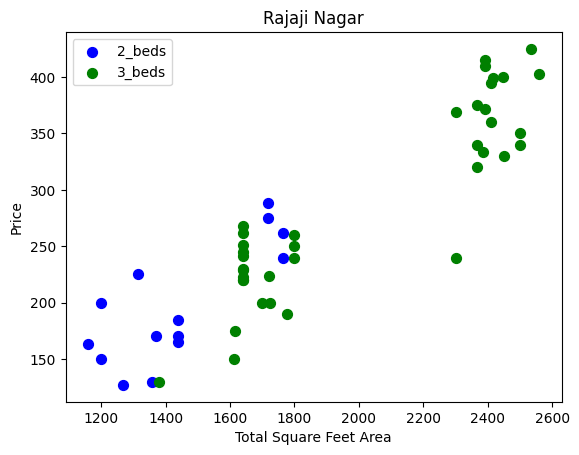

In [ ]:
def plot_scatter_chart(df, location):
  bed2 = df[(df.location==location) & (df.bedrooms==2)]
  bed3 = df[(df.location==location) & (df.bedrooms==3)]
  plt.scatter(bed2.total_sqft, bed2.price, color='blue', label='2_beds', s=50)
  plt.scatter(bed3.total_sqft, bed3.price, color='green', label='3_beds', s=50)
  plt.xlabel('Total Square Feet Area')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()

plot_scatter_chart(df1, 'Rajaji Nagar')

The problem we have right now is that there are 3 bedroom places that are less than some 2 bedroom places in the same location which doesn't make sense.

We need to remove places where ex a 2 bedroom apt price is less than a 1 bedroom apt in the same location

In [ ]:
def remove_bedroom_outliers(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bedrooms_stats = {}
    for bedroom, bedroom_df in location_df.groupby('bedrooms'):
      bedrooms_stats[bedroom] = {
          'mean': np.mean(bedroom_df.price_per_sqft),
          'std': np.std(bedroom_df.price_per_sqft),
          'count': bedroom_df.shape[0]
      }
    for bedroom, bedroom_df in location_df.groupby('bedrooms'):
      stats = bedrooms_stats.get(bedroom-1)
      if stats and stats['count']>5:
        exclude_indices = np.append(exclude_indices, bedroom_df[bedroom_df.price_per_sqft<(stats['mean'])].index.values)
  return df.drop(exclude_indices, axis='index')

In [ ]:
df2 = remove_bedroom_outliers(df1)
df2.shape

(7317, 7)

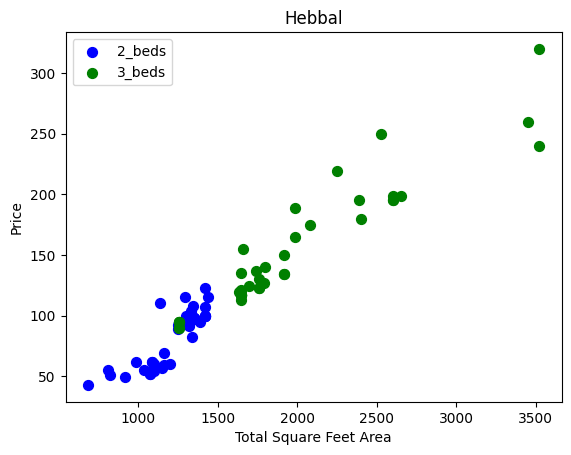

In [ ]:
plot_scatter_chart(df2, 'Hebbal')

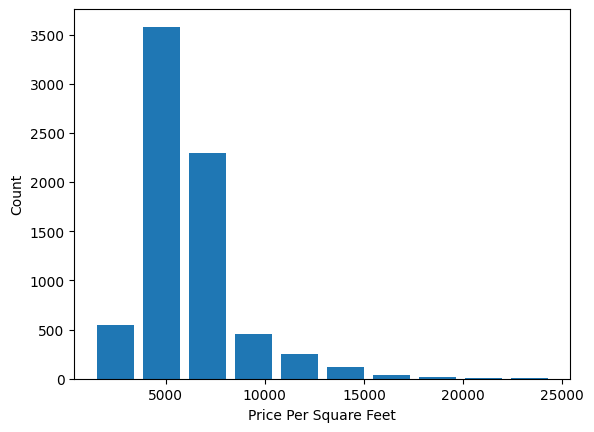

In [ ]:
plt.hist(df2.price_per_sqft, rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')
None

I have most of my data from 0- 10000 sqaure feet. Its also normally distributed there

In [ ]:
df2.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

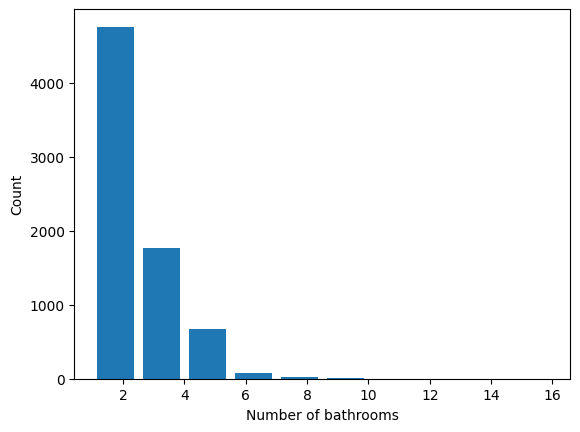

In [ ]:
plt.hist(df2.bath, rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
None

Its weird to have more bathrooms than bedrooms

In [ ]:
df3 = df2[df2.bath<df2.bedrooms+2]
df3.shape

(7239, 7)

In [ ]:
#Dropping features we don't need
df4 = df3.drop(['size', 'price_per_sqft'], axis=1)
df4.head()

,location,total_sqft,bath,price,bedrooms
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


Machine Learning Model:




need to convert text to numeric variable. We will do this through one hot encoding

In [ ]:
dummies = pd.get_dummies(df4.location, dtype=int)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df5 = pd.concat([df4, dummies.drop('other', axis=1)], axis=1)
df5.head()

,location,total_sqft,bath,price,bedrooms,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df5.drop('location', axis=1, inplace=True)
df5.head()

,total_sqft,bath,price,bedrooms,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df5.shape

(7251, 245)

In [ ]:
X = df5.drop('price', axis=1)
y = df5.price

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
lg_model = LinearRegression()
lg_model.fit(X_train, y_train)
lg_model.score(X_test, y_test)

0.8452277697874329

In [ ]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

def model_grid_search(X, y):
  algos = {
      'linear_regression': {
          'model': LinearRegression(),
          'params': {
              'fit_intercept': [True, False]
          }
      },
      'lasso': {
          'model': Lasso(),
          'params': {
              'alpha': [1, 2],
              'selection': ['random', 'cyclic']
          }
      },
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['mse', 'friedman_mse'],
              'splitter': ['best', 'random']
          }
      }
  }
  scores = []
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X, y)
    scores.append({
        'model': algo,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })
  return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [ ]:
model_grid_search(X,y)

,model,best_score,best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.714542,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [ ]:
def predict_price(location, sqft, bath, bedrooms):
  loc_index = np.where(X.columns==location)[0][0]
  x= np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bedrooms
  if loc_index >= 0:
    x[loc_index] = 1
  return lg_model.predict([x])[0]

predict_price('1st Phase JP Nagar', 1000, 2,2)

83.49904677188148

In [ ]:
predict_price('1st Phase JP Nagar', 1000, 3,3)

86.80519395214823

In [ ]:
predict_price('Indira Nagar', 1000, 2,2)

181.27815484006715

In [ ]:
import pickle
with open('bangalore_home_prices.pickle', 'wb') as f:
  pickle.dump(lg_model, f)

import json
columns = {
  'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
  f.write(json.dumps(columns))